<a href="https://colab.research.google.com/github/Maitrey185/Pixour/blob/main/Pixour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Neural Style Transfer



In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import numpy as np
from PIL import Image
import time
import functools
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2
import os

mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

In [ ]:
import tensorflow as tf

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [ ]:
#tf.enable_eager_execution()
#print("Eager execution: {}".format(tf.executing_eagerly()))

In [ ]:
# Set up some global values here
content_path = "/content/drive/My Drive/Neural Style Transfer/Content Images/content10.jpg"
style_path = "/content/drive/My Drive/Neural Style Transfer/Style Images/style13.jpg"

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

In [ ]:
def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

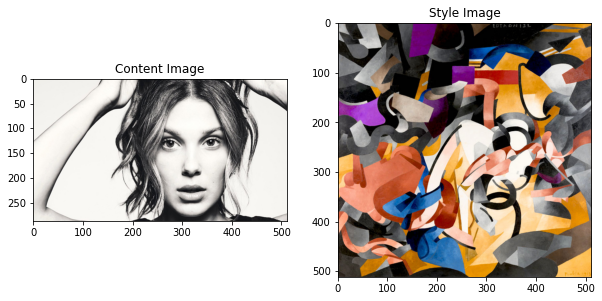

In [ ]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

In [ ]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [ ]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [ ]:
def postprocess(img):
  imgpost = np.copy(img)
  imgpost += np.array([103.939, 116.779, 123.68]).reshape((1,1,1,3))
  # shape (1, h, w, d) to (h, w, d)
  imgpost = imgpost[0]
  #imgpost = np.clip(imgpost, 0, 255).astype('uint8')
  return imgpost

In [ ]:
def preprocess(img):
  imgpre = np.copy(img)

  # shape (h, w, d) to (1, h, w, d)
  imgpre = imgpre[np.newaxis,:,:,:]
  imgpre -= np.array([103.939, 116.779, 123.68]).reshape((1,1,1,3))
  return imgpre

In [ ]:
def convert_to_original_colors(content_img, stylized_img):
  content_img  = postprocess(content_img)
  stylized_img = postprocess(stylized_img)
#  print(type(content_img))
#  print(type(stylized_img))

  s_img = cv2.resize(stylized_img, dsize=(512, 288), interpolation=cv2.INTER_CUBIC)

#  print(content_img.shape)
#  print(s_img.shape)

  cvt_type = cv2.COLOR_BGR2YUV
  inv_cvt_type = cv2.COLOR_YUV2BGR

  content_cvt = cv2.cvtColor(np.float32(content_img), cvt_type)
  stylized_cvt = cv2.cvtColor(np.float32(s_img), cvt_type)
 
  #c1, _, _ = cv2.split(stylized_cvt)
  #_, c2, c3 = cv2.split(content_cvt)
  #merged = cv2.merge((c1, c2, c3))
  
  stylized_cvt[:,:,1:3] = content_cvt[:,:,1:3]
  dst = cv2.cvtColor(stylized_cvt, inv_cvt_type).astype(np.float32)
# dst = dst.resize(512,394,3)
  dst = preprocess(dst)
  dst1 = preprocess(content_img)
  return dst, dst1

In [ ]:
#  parser.add_argument('--content_layers', nargs='+', type=str, 
#     default=['conv4_2'],
#     help='VGG19 layers used for the content image. (default: %(default)s)')
  
#   parser.add_argument('--style_layers', nargs='+', type=str,
#     default=['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1'],
#     help='VGG19 layers used for the style image. (default: %(default)s)')
  

In [ ]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv1'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
                ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def get_model():
  """ Creates our model with access to intermediate layers. 
  
  This function will load the VGG19 model and access the intermediate layers. 
  These layers will then be used to create a new model that will take input image
  and return the outputs from these intermediate layers from the VGG model. 
  
  Returns:
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers. 
  """
  # Load our model. We load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(vgg.input, model_outputs)

In [ ]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

In [ ]:
def tv_loss(c_path):
  c_img = load_and_process_img(c_path)
  return 0.5 * (np.abs(c_img[:, :, 1:, :] - c_img[:, :, :-1, :]).mean() +
                  np.abs(c_img[:, :, :, 1:] - c_img[:, :, :, :-1]).mean())

In [ ]:
#def temporal_loss(x, w, c):
#  c = c[np.newaxis,:,:,:]
#  D = float(x.size)
#  loss = (1. / D) * tf.reduce_sum(c * tf.nn.l2_loss(x - w))
#  loss = tf.cast(loss, tf.float32)
#  return loss

In [ ]:
def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""
  # height, width, num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

In [ ]:
def get_feature_representations(model, content_path, style_path):
  """Helper function to compute our content and style feature representations.

  This function will simply load and preprocess both the content and style 
  images from their path. Then it will feed them through the network to obtain
  the outputs of the intermediate layers. 
  
  Arguments:
    model: The model that we are using.
    content_path: The path to the content image.
    style_path: The path to the style image
    
  Returns:
    returns the style features and the content features. 
  """
  # Load our images in 
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)

  style_image, content_image = convert_to_original_colors(content_image, style_image)

  # batch compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  
  # Get the style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

In [ ]:
def mask_style_layer(a, x, mask_img):
  h, w, d = a.get_shape()
  mask = get_mask_image(mask_img, w, h)
  mask = tf.convert_to_tensor(mask)
  tensors = []
  for _ in range(d): 
    tensors.append(mask)
  mask = tf.stack(tensors, axis=2)
  mask = tf.stack(mask, axis=0)
  mask = tf.expand_dims(mask, 0)
  a = tf.multiply(a, mask)
  x = tf.multiply(x, mask)
  return a, x

In [ ]:
def get_mask_image(mask_img, width, height):
  path = os.path.join(content_path, mask_img)
  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_AREA)
  img = img.astype(np.float32)
  mx = np.amax(img)
  img /= mx
  return img

In [ ]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  """This function will compute the loss total loss.
  
  Arguments:
    model: The model that will give us access to the intermediate layers
    loss_weights: The weights of each contribution of each loss function. 
      (style weight, content weight, and total variation weight)
    init_image: Our initial base image. This image is what we are updating with 
      our optimization process. We apply the gradients wrt the loss we are 
      calculating to this image.
    gram_style_features: Precomputed gram matrices corresponding to the 
      defined style layers of interest.
    content_features: Precomputed outputs from defined content layers of 
      interest.
      
  Returns:
    returns the total loss, style loss, content loss, and total variational loss
  """
  style_weight, content_weight = loss_weights
  
  # Feed our init image through our model. This will give us the content and 
  # style representations at our desired layers. Since we're using eager
  # our model is callable just like any other function!
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0
  tv_score = tv_loss(content_path)

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  img_mask = "/content/drive/My Drive/Neural Style Transfer/Content Images/newDog.jpeg"
  for target_style, comb_style in zip(gram_style_features, style_output_features):
#    a, x = mask_style_layer(comb_style[0], target_style, img_mask)
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
#    style_score += weight_per_style_layer * get_style_loss(a, target_style)

  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight
  tv_score *= 1e5 
  
  # Get total loss
  loss = style_score + content_score + tv_score
  return loss, style_score, content_score

In [ ]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

In [ ]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1500,
                       content_weight=1e3, 
                       style_weight=1e-2): 
  # We don't need to (or want to) train any layers of our model, so we set their
  # trainable to false. 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = tf.keras.optimizers.Adam(learning_rate=2, beta_1=0.99, epsilon=1e-1)

  # For displaying intermediate images 
  iter_count = 1
  
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
  
  # For displaying
  num_rows = 3
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss 

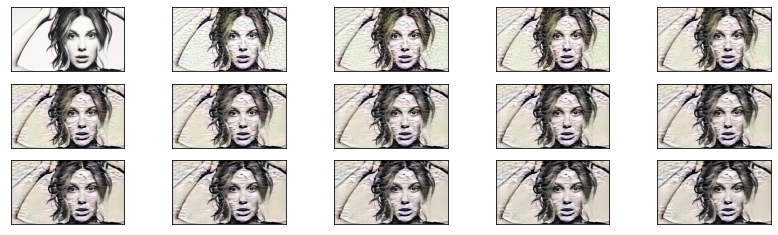

In [ ]:
best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=1500)

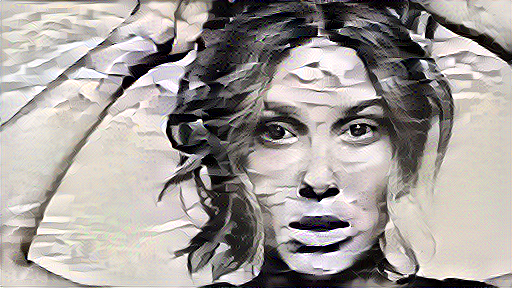

In [ ]:
Image.fromarray(best)

In [ ]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

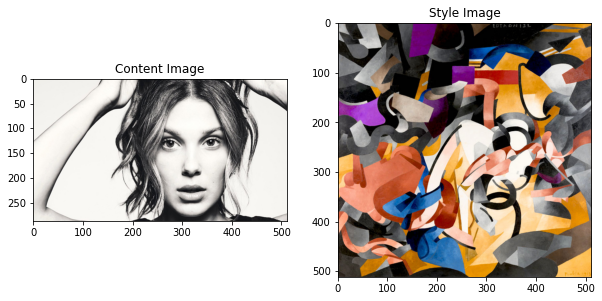

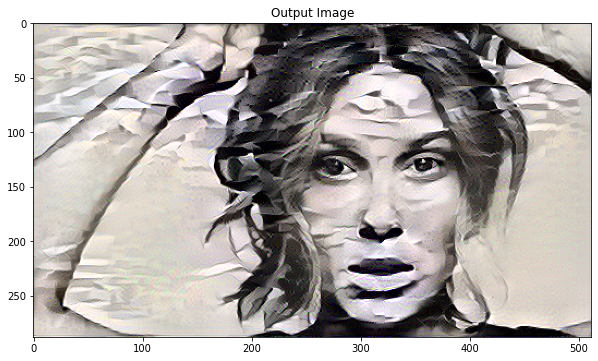

In [ ]:
show_results(best, content_path, style_path)